In [12]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'


In [13]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [14]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[1].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [15]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [16]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


In [18]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:04<00:00,  3.57it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:05<00:00, 45.62it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:22<00:00,  2.94it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:04<00:00, 57.19it/s]


In [19]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   1%|          | 11/2000 [00:01<03:24,  9.71it/s]

Epoch 10/2000, Loss: 0.6767
Test Accuracy at Epoch 10: 63.16%
Test F1-score at Epoch 10: 0.6682
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.69      0.51      0.59       194
non_infringement       0.60      0.76      0.67       186

        accuracy                           0.63       380
       macro avg       0.64      0.63      0.63       380
    weighted avg       0.64      0.63      0.63       380

New best model saved with F1-score 0.6682 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.69      0.51      0.59       194
non_infringement       0.60      0.76      0.67       186

        accuracy                           0.63       380
       macro avg       0.64      0.63      0.63       380
    weighted avg       0.64      0.63      0.63       380



Training Epochs:   1%|          | 21/2000 [00:01<02:42, 12.16it/s]

Epoch 20/2000, Loss: 0.6477
Test Accuracy at Epoch 20: 63.42%
Test F1-score at Epoch 20: 0.6775
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.70      0.49      0.58       194
non_infringement       0.60      0.78      0.68       186

        accuracy                           0.63       380
       macro avg       0.65      0.64      0.63       380
    weighted avg       0.65      0.63      0.63       380

New best model saved with F1-score 0.6775 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.70      0.49      0.58       194
non_infringement       0.60      0.78      0.68       186

        accuracy                           0.63       380
       macro avg       0.65      0.64      0.63       380
    weighted avg       0.65      0.63      0.63       380



Training Epochs:   2%|▏         | 31/2000 [00:02<02:35, 12.68it/s]

Epoch 30/2000, Loss: 0.5967
Test Accuracy at Epoch 30: 61.58%
Test F1-score at Epoch 30: 0.6894
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.75      0.37      0.50       194
non_infringement       0.57      0.87      0.69       186

        accuracy                           0.62       380
       macro avg       0.66      0.62      0.59       380
    weighted avg       0.66      0.62      0.59       380

New best model saved with F1-score 0.6894 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.75      0.37      0.50       194
non_infringement       0.57      0.87      0.69       186

        accuracy                           0.62       380
       macro avg       0.66      0.62      0.59       380
    weighted avg       0.66      0.62      0.59       380



Training Epochs:   2%|▏         | 42/2000 [00:03<02:08, 15.27it/s]

Epoch 40/2000, Loss: 0.5343
Test Accuracy at Epoch 40: 60.53%
Test F1-score at Epoch 40: 0.7070
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.91      0.25      0.40       194
non_infringement       0.56      0.97      0.71       186

        accuracy                           0.61       380
       macro avg       0.73      0.61      0.55       380
    weighted avg       0.74      0.61      0.55       380

New best model saved with F1-score 0.7070 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.91      0.25      0.40       194
non_infringement       0.56      0.97      0.71       186

        accuracy                           0.61       380
       macro avg       0.73      0.61      0.55       380
    weighted avg       0.74      0.61      0.55       380



Training Epochs:   2%|▎         | 50/2000 [00:03<02:07, 15.27it/s]

Epoch 50/2000, Loss: 0.5023
Test Accuracy at Epoch 50: 64.21%
Test F1-score at Epoch 50: 0.7119
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.81      0.39      0.53       194
non_infringement       0.59      0.90      0.71       186

        accuracy                           0.64       380
       macro avg       0.70      0.65      0.62       380
    weighted avg       0.70      0.64      0.62       380

New best model saved with F1-score 0.7119 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.81      0.39      0.53       194
non_infringement       0.59      0.90      0.71       186

        accuracy                           0.64       380
       macro avg       0.70      0.65      0.62       380
    weighted avg       0.70      0.64      0.62       380



Training Epochs:   3%|▎         | 61/2000 [00:05<04:22,  7.38it/s]

Epoch 60/2000, Loss: 0.4479
Test Accuracy at Epoch 60: 73.95%
Test F1-score at Epoch 60: 0.7692
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380

New best model saved with F1-score 0.7692 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:   4%|▎         | 73/2000 [00:05<01:48, 17.75it/s]

Epoch 70/2000, Loss: 0.4335
Test Accuracy at Epoch 70: 71.32%
Test F1-score at Epoch 70: 0.7604
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.88      0.51      0.64       194
non_infringement       0.64      0.93      0.76       186

        accuracy                           0.71       380
       macro avg       0.76      0.72      0.70       380
    weighted avg       0.77      0.71      0.70       380



Training Epochs:   4%|▍         | 80/2000 [00:06<03:05, 10.34it/s]

Epoch 80/2000, Loss: 0.4057
Test Accuracy at Epoch 80: 71.58%
Test F1-score at Epoch 80: 0.7702
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.95      0.47      0.63       194
non_infringement       0.64      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.72      0.70       380
    weighted avg       0.80      0.72      0.70       380

New best model saved with F1-score 0.7702 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.95      0.47      0.63       194
non_infringement       0.64      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.72      0.70       380
    weighted avg       0.80      0.72      0.70       380



Training Epochs:   4%|▍         | 90/2000 [00:08<08:04,  3.94it/s]

Epoch 90/2000, Loss: 0.3542
Test Accuracy at Epoch 90: 76.84%
Test F1-score at Epoch 90: 0.7953
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.89      0.62      0.73       194
non_infringement       0.70      0.92      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.80      0.77      0.76       380

New best model saved with F1-score 0.7953 at epoch 90
Best Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.89      0.62      0.73       194
non_infringement       0.70      0.92      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.80      0.77      0.76       380



Training Epochs:   5%|▌         | 100/2000 [00:14<16:56,  1.87it/s]

Epoch 100/2000, Loss: 0.3656
Test Accuracy at Epoch 100: 77.11%
Test F1-score at Epoch 100: 0.7704
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.79      0.76      0.77       194
non_infringement       0.76      0.78      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:   6%|▌         | 110/2000 [00:16<04:27,  7.06it/s]

Epoch 110/2000, Loss: 0.3167
Test Accuracy at Epoch 110: 79.47%
Test F1-score at Epoch 110: 0.8107
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.88      0.70      0.78       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380

New best model saved with F1-score 0.8107 at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.88      0.70      0.78       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:   6%|▌         | 120/2000 [00:20<15:48,  1.98it/s]

Epoch 120/2000, Loss: 0.3016
Test Accuracy at Epoch 120: 78.42%
Test F1-score at Epoch 120: 0.8066
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.89      0.65      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:   6%|▋         | 130/2000 [00:25<16:35,  1.88it/s]

Epoch 130/2000, Loss: 0.2957
Test Accuracy at Epoch 130: 78.16%
Test F1-score at Epoch 130: 0.7810
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.80      0.77      0.78       194
non_infringement       0.77      0.80      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:   7%|▋         | 140/2000 [00:30<17:25,  1.78it/s]

Epoch 140/2000, Loss: 0.3019
Test Accuracy at Epoch 140: 81.05%
Test F1-score at Epoch 140: 0.8318
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.94      0.67      0.78       194
non_infringement       0.74      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380

New best model saved with F1-score 0.8318 at epoch 140
Best Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.94      0.67      0.78       194
non_infringement       0.74      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:   8%|▊         | 150/2000 [00:36<19:13,  1.60it/s]

Epoch 150/2000, Loss: 0.2701
Test Accuracy at Epoch 150: 82.11%
Test F1-score at Epoch 150: 0.8389
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.94      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.85      0.82      0.82       380

New best model saved with F1-score 0.8389 at epoch 150
Best Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.94      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:   8%|▊         | 160/2000 [00:40<10:09,  3.02it/s]

Epoch 160/2000, Loss: 0.2600
Test Accuracy at Epoch 160: 81.32%
Test F1-score at Epoch 160: 0.8184
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.85      0.77      0.81       194
non_infringement       0.78      0.86      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:   8%|▊         | 169/2000 [00:44<15:15,  2.00it/s]

Epoch 170/2000, Loss: 0.2487
Test Accuracy at Epoch 170: 82.89%
Test F1-score at Epoch 170: 0.8449
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:   8%|▊         | 170/2000 [00:45<17:51,  1.71it/s]

New best model saved with F1-score 0.8449 at epoch 170
Best Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:   9%|▉         | 180/2000 [00:51<16:48,  1.80it/s]

Epoch 180/2000, Loss: 0.2493
Test Accuracy at Epoch 180: 80.26%
Test F1-score at Epoch 180: 0.8052
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.83      0.77      0.80       194
non_infringement       0.78      0.83      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.80      0.80      0.80       380



Training Epochs:  10%|▉         | 190/2000 [00:56<16:11,  1.86it/s]

Epoch 190/2000, Loss: 0.2448
Test Accuracy at Epoch 190: 81.32%
Test F1-score at Epoch 190: 0.8184
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.85      0.77      0.81       194
non_infringement       0.78      0.86      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  10%|█         | 201/2000 [01:01<10:04,  2.98it/s]

Epoch 200/2000, Loss: 0.2370
Test Accuracy at Epoch 200: 83.68%
Test F1-score at Epoch 200: 0.8502
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380

New best model saved with F1-score 0.8502 at epoch 200
Best Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  10%|█         | 209/2000 [01:03<12:11,  2.45it/s]

Epoch 210/2000, Loss: 0.4052


Training Epochs:  10%|█         | 210/2000 [01:04<18:25,  1.62it/s]

Test Accuracy at Epoch 210: 69.21%
Test F1-score at Epoch 210: 0.7598
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.99      0.40      0.57       194
non_infringement       0.61      0.99      0.76       186

        accuracy                           0.69       380
       macro avg       0.80      0.70      0.67       380
    weighted avg       0.80      0.69      0.66       380



Training Epochs:  11%|█         | 220/2000 [01:09<15:52,  1.87it/s]

Epoch 220/2000, Loss: 0.3250
Test Accuracy at Epoch 220: 84.21%
Test F1-score at Epoch 220: 0.8515
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.91      0.76      0.83       194
non_infringement       0.79      0.92      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380

New best model saved with F1-score 0.8515 at epoch 220
Best Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.91      0.76      0.83       194
non_infringement       0.79      0.92      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  12%|█▏        | 230/2000 [01:15<15:41,  1.88it/s]

Epoch 230/2000, Loss: 0.2410
Test Accuracy at Epoch 230: 84.21%
Test F1-score at Epoch 230: 0.8537
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.93      0.75      0.83       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380

New best model saved with F1-score 0.8537 at epoch 230
Best Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.93      0.75      0.83       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  12%|█▏        | 240/2000 [01:20<15:19,  1.91it/s]

Epoch 240/2000, Loss: 0.2170
Test Accuracy at Epoch 240: 83.95%
Test F1-score at Epoch 240: 0.8516
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.93      0.74      0.83       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  12%|█▎        | 250/2000 [01:21<04:27,  6.55it/s]

Epoch 250/2000, Loss: 0.2110
Test Accuracy at Epoch 250: 83.95%
Test F1-score at Epoch 250: 0.8509
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.92      0.75      0.83       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  13%|█▎        | 260/2000 [01:26<13:28,  2.15it/s]

Epoch 260/2000, Loss: 0.2030
Test Accuracy at Epoch 260: 83.95%
Test F1-score at Epoch 260: 0.8509
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.92      0.75      0.83       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  14%|█▎        | 270/2000 [01:26<02:34, 11.23it/s]

Epoch 270/2000, Loss: 0.1947
Test Accuracy at Epoch 270: 83.95%
Test F1-score at Epoch 270: 0.8509
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.92      0.75      0.83       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  14%|█▍        | 280/2000 [01:31<13:36,  2.11it/s]

Epoch 280/2000, Loss: 0.3533
Test Accuracy at Epoch 280: 80.53%
Test F1-score at Epoch 280: 0.8083
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.83      0.77      0.80       194
non_infringement       0.78      0.84      0.81       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.81       380
    weighted avg       0.81      0.81      0.81       380



Training Epochs:  14%|█▍        | 290/2000 [01:36<16:09,  1.76it/s]

Epoch 290/2000, Loss: 0.2580
Test Accuracy at Epoch 290: 84.47%
Test F1-score at Epoch 290: 0.8543
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.92      0.76      0.83       194
non_infringement       0.79      0.93      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.85      0.84       380
    weighted avg       0.86      0.84      0.84       380

New best model saved with F1-score 0.8543 at epoch 290
Best Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.92      0.76      0.83       194
non_infringement       0.79      0.93      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.85      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  15%|█▌        | 300/2000 [01:41<15:04,  1.88it/s]

Epoch 300/2000, Loss: 0.1981
Test Accuracy at Epoch 300: 83.42%
Test F1-score at Epoch 300: 0.8467
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.92      0.74      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  16%|█▌        | 310/2000 [01:46<11:37,  2.42it/s]

Epoch 310/2000, Loss: 0.1965
Test Accuracy at Epoch 310: 82.89%
Test F1-score at Epoch 310: 0.8426
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.92      0.73      0.81       194
non_infringement       0.77      0.94      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  16%|█▌        | 320/2000 [01:49<09:27,  2.96it/s]

Epoch 320/2000, Loss: 0.1889
Test Accuracy at Epoch 320: 83.68%
Test F1-score at Epoch 320: 0.8488
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.92      0.74      0.82       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  16%|█▋        | 329/2000 [01:54<16:26,  1.69it/s]

Epoch 330/2000, Loss: 0.1810
Test Accuracy at Epoch 330: 83.68%
Test F1-score at Epoch 330: 0.8488


Training Epochs:  16%|█▋        | 330/2000 [01:55<20:04,  1.39it/s]

Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.92      0.74      0.82       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  17%|█▋        | 340/2000 [02:02<17:40,  1.57it/s]

Epoch 340/2000, Loss: 0.1763
Test Accuracy at Epoch 340: 83.68%
Test F1-score at Epoch 340: 0.8488
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.92      0.74      0.82       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  18%|█▊        | 350/2000 [02:07<15:46,  1.74it/s]

Epoch 350/2000, Loss: 0.1733
Test Accuracy at Epoch 350: 82.11%
Test F1-score at Epoch 350: 0.8317
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.89      0.74      0.81       194
non_infringement       0.77      0.90      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  18%|█▊        | 359/2000 [02:12<13:59,  1.96it/s]

Epoch 360/2000, Loss: 0.2823


Training Epochs:  18%|█▊        | 360/2000 [02:13<16:41,  1.64it/s]

Test Accuracy at Epoch 360: 76.05%
Test F1-score at Epoch 360: 0.7973
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.94      0.57      0.71       194
non_infringement       0.68      0.96      0.80       186

        accuracy                           0.76       380
       macro avg       0.81      0.76      0.75       380
    weighted avg       0.81      0.76      0.75       380



Training Epochs:  18%|█▊        | 370/2000 [02:18<15:48,  1.72it/s]

Epoch 370/2000, Loss: 0.1732
Test Accuracy at Epoch 370: 82.37%
Test F1-score at Epoch 370: 0.8393
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  19%|█▉        | 380/2000 [02:24<15:56,  1.69it/s]

Epoch 380/2000, Loss: 0.1823
Test Accuracy at Epoch 380: 82.11%
Test F1-score at Epoch 380: 0.8317
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.89      0.74      0.81       194
non_infringement       0.77      0.90      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  20%|█▉        | 390/2000 [02:29<14:30,  1.85it/s]

Epoch 390/2000, Loss: 0.1687
Test Accuracy at Epoch 390: 83.16%
Test F1-score at Epoch 390: 0.8439
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.92      0.74      0.82       194
non_infringement       0.77      0.93      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  20%|██        | 400/2000 [02:35<14:11,  1.88it/s]

Epoch 400/2000, Loss: 0.1625
Test Accuracy at Epoch 400: 82.37%
Test F1-score at Epoch 400: 0.8346
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.89      0.74      0.81       194
non_infringement       0.77      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.83      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  20%|██        | 410/2000 [02:39<09:33,  2.77it/s]

Epoch 410/2000, Loss: 0.1556
Test Accuracy at Epoch 410: 82.11%
Test F1-score at Epoch 410: 0.8325
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.89      0.74      0.81       194
non_infringement       0.77      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  21%|██        | 419/2000 [02:44<14:02,  1.88it/s]

Epoch 420/2000, Loss: 0.3911
Test Accuracy at Epoch 420: 81.84%
Test F1-score at Epoch 420: 0.8198


Training Epochs:  21%|██        | 420/2000 [02:44<15:37,  1.69it/s]

Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.84      0.79      0.82       194
non_infringement       0.80      0.84      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  22%|██▏       | 430/2000 [02:50<14:57,  1.75it/s]

Epoch 430/2000, Loss: 0.2306
Test Accuracy at Epoch 430: 82.11%
Test F1-score at Epoch 430: 0.8325
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.89      0.74      0.81       194
non_infringement       0.77      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  22%|██▏       | 440/2000 [02:55<14:36,  1.78it/s]

Epoch 440/2000, Loss: 0.1831
Test Accuracy at Epoch 440: 81.58%
Test F1-score at Epoch 440: 0.8317
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.80       194
non_infringement       0.75      0.93      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  22%|██▎       | 450/2000 [03:01<14:11,  1.82it/s]

Epoch 450/2000, Loss: 0.1631
Test Accuracy at Epoch 450: 82.11%
Test F1-score at Epoch 450: 0.8357
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.93      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  23%|██▎       | 464/2000 [03:05<03:55,  6.53it/s]

Epoch 460/2000, Loss: 0.1521
Test Accuracy at Epoch 460: 82.37%
Test F1-score at Epoch 460: 0.8386
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.92      0.72      0.81       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  24%|██▎       | 470/2000 [03:06<06:19,  4.03it/s]

Epoch 470/2000, Loss: 0.1484
Test Accuracy at Epoch 470: 81.84%
Test F1-score at Epoch 470: 0.8305
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.89      0.73      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  24%|██▍       | 480/2000 [03:12<13:43,  1.85it/s]

Epoch 480/2000, Loss: 0.1439
Test Accuracy at Epoch 480: 82.63%
Test F1-score at Epoch 480: 0.8398
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.92      0.73      0.81       194
non_infringement       0.77      0.93      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.82       380



Training Epochs:  24%|██▍       | 490/2000 [03:17<14:59,  1.68it/s]

Epoch 490/2000, Loss: 0.1410
Test Accuracy at Epoch 490: 81.84%
Test F1-score at Epoch 490: 0.8305
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.89      0.73      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  25%|██▌       | 500/2000 [03:22<13:34,  1.84it/s]

Epoch 500/2000, Loss: 0.2442
Test Accuracy at Epoch 500: 82.37%
Test F1-score at Epoch 500: 0.8278
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.86      0.78      0.82       194
non_infringement       0.79      0.87      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  26%|██▌       | 510/2000 [03:28<14:47,  1.68it/s]

Epoch 510/2000, Loss: 0.1651
Test Accuracy at Epoch 510: 72.11%
Test F1-score at Epoch 510: 0.7686
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.91      0.51      0.65       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.72      0.71       380



Training Epochs:  26%|██▌       | 520/2000 [03:33<13:43,  1.80it/s]

Epoch 520/2000, Loss: 0.1723
Test Accuracy at Epoch 520: 82.37%
Test F1-score at Epoch 520: 0.8337
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.89      0.75      0.81       194
non_infringement       0.77      0.90      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.83      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  26%|██▋       | 530/2000 [03:38<12:49,  1.91it/s]

Epoch 530/2000, Loss: 0.1415
Test Accuracy at Epoch 530: 81.84%
Test F1-score at Epoch 530: 0.8305
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.89      0.73      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  27%|██▋       | 540/2000 [03:43<13:01,  1.87it/s]

Epoch 540/2000, Loss: 0.1418
Test Accuracy at Epoch 540: 82.11%
Test F1-score at Epoch 540: 0.8357
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.93      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  28%|██▊       | 550/2000 [03:47<08:52,  2.73it/s]

Epoch 550/2000, Loss: 0.1364
Test Accuracy at Epoch 550: 81.05%
Test F1-score at Epoch 550: 0.8244
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.89      0.72      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  28%|██▊       | 560/2000 [03:52<13:17,  1.80it/s]

Epoch 560/2000, Loss: 0.1322
Test Accuracy at Epoch 560: 76.58%
Test F1-score at Epoch 560: 0.7954
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.90      0.61      0.73       194
non_infringement       0.69      0.93      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.77      0.76       380
    weighted avg       0.80      0.77      0.76       380



Training Epochs:  28%|██▊       | 570/2000 [03:58<13:33,  1.76it/s]

Epoch 570/2000, Loss: 0.1304
Test Accuracy at Epoch 570: 81.05%
Test F1-score at Epoch 570: 0.8244
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.89      0.72      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  29%|██▉       | 580/2000 [04:03<12:40,  1.87it/s]

Epoch 580/2000, Loss: 0.1299
Test Accuracy at Epoch 580: 81.05%
Test F1-score at Epoch 580: 0.8244
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.89      0.72      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  30%|██▉       | 590/2000 [04:08<12:57,  1.81it/s]

Epoch 590/2000, Loss: 0.2409
Test Accuracy at Epoch 590: 73.68%
Test F1-score at Epoch 590: 0.7835
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.95      0.51      0.66       194
non_infringement       0.66      0.97      0.78       186

        accuracy                           0.74       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.81      0.74      0.72       380



Training Epochs:  30%|███       | 601/2000 [04:13<06:42,  3.48it/s]

Epoch 600/2000, Loss: 0.1354
Test Accuracy at Epoch 600: 73.42%
Test F1-score at Epoch 600: 0.7770
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.91      0.53      0.67       194
non_infringement       0.66      0.95      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  30%|███       | 610/2000 [04:16<12:06,  1.91it/s]

Epoch 610/2000, Loss: 0.1428
Test Accuracy at Epoch 610: 81.32%
Test F1-score at Epoch 610: 0.8273
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  31%|███       | 620/2000 [04:21<12:44,  1.81it/s]

Epoch 620/2000, Loss: 0.1310
Test Accuracy at Epoch 620: 81.58%
Test F1-score at Epoch 620: 0.8301
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  32%|███▏      | 630/2000 [04:26<10:05,  2.26it/s]

Epoch 630/2000, Loss: 0.1284
Test Accuracy at Epoch 630: 75.26%
Test F1-score at Epoch 630: 0.7864
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.90      0.58      0.71       194
non_infringement       0.68      0.93      0.79       186

        accuracy                           0.75       380
       macro avg       0.79      0.76      0.75       380
    weighted avg       0.79      0.75      0.75       380



Training Epochs:  32%|███▏      | 642/2000 [04:28<02:33,  8.86it/s]

Epoch 640/2000, Loss: 0.1251
Test Accuracy at Epoch 640: 75.79%
Test F1-score at Epoch 640: 0.7900
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.90      0.59      0.71       194
non_infringement       0.69      0.93      0.79       186

        accuracy                           0.76       380
       macro avg       0.79      0.76      0.75       380
    weighted avg       0.79      0.76      0.75       380



Training Epochs:  33%|███▎      | 652/2000 [04:29<02:04, 10.81it/s]

Epoch 650/2000, Loss: 0.1233
Test Accuracy at Epoch 650: 75.00%
Test F1-score at Epoch 650: 0.7806
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.87      0.60      0.71       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.75       380
    weighted avg       0.78      0.75      0.74       380



Training Epochs:  33%|███▎      | 660/2000 [04:30<02:10, 10.28it/s]

Epoch 660/2000, Loss: 0.1217
Test Accuracy at Epoch 660: 75.79%
Test F1-score at Epoch 660: 0.7900
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.90      0.59      0.71       194
non_infringement       0.69      0.93      0.79       186

        accuracy                           0.76       380
       macro avg       0.79      0.76      0.75       380
    weighted avg       0.79      0.76      0.75       380



Training Epochs:  34%|███▎      | 670/2000 [04:31<02:54,  7.63it/s]

Epoch 670/2000, Loss: 0.1205
Test Accuracy at Epoch 670: 75.00%
Test F1-score at Epoch 670: 0.7806
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.87      0.60      0.71       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.75       380
    weighted avg       0.78      0.75      0.74       380



Training Epochs:  34%|███▍      | 680/2000 [04:37<12:01,  1.83it/s]

Epoch 680/2000, Loss: 0.2397
Test Accuracy at Epoch 680: 74.47%
Test F1-score at Epoch 680: 0.7810
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  34%|███▍      | 690/2000 [04:42<11:55,  1.83it/s]

Epoch 690/2000, Loss: 0.1324
Test Accuracy at Epoch 690: 81.32%
Test F1-score at Epoch 690: 0.8264
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.89      0.72      0.80       194
non_infringement       0.76      0.91      0.83       186

        accuracy                           0.81       380
       macro avg       0.82      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  35%|███▌      | 700/2000 [04:47<11:40,  1.86it/s]

Epoch 700/2000, Loss: 0.1254
Test Accuracy at Epoch 700: 74.74%
Test F1-score at Epoch 700: 0.7838
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.90      0.57      0.70       194
non_infringement       0.67      0.94      0.78       186

        accuracy                           0.75       380
       macro avg       0.79      0.75      0.74       380
    weighted avg       0.79      0.75      0.74       380



Training Epochs:  36%|███▌      | 710/2000 [04:52<12:37,  1.70it/s]

Epoch 710/2000, Loss: 0.1241
Test Accuracy at Epoch 710: 80.79%
Test F1-score at Epoch 710: 0.8241
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.90      0.70      0.79       194
non_infringement       0.75      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  36%|███▌      | 720/2000 [04:57<11:19,  1.88it/s]

Epoch 720/2000, Loss: 0.1195
Test Accuracy at Epoch 720: 75.53%
Test F1-score at Epoch 720: 0.7882
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.90      0.59      0.71       194
non_infringement       0.68      0.93      0.79       186

        accuracy                           0.76       380
       macro avg       0.79      0.76      0.75       380
    weighted avg       0.79      0.76      0.75       380



Training Epochs:  36%|███▋      | 730/2000 [05:02<11:20,  1.87it/s]

Epoch 730/2000, Loss: 0.1184
Test Accuracy at Epoch 730: 74.74%
Test F1-score at Epoch 730: 0.7828
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.90      0.57      0.70       194
non_infringement       0.68      0.93      0.78       186

        accuracy                           0.75       380
       macro avg       0.79      0.75      0.74       380
    weighted avg       0.79      0.75      0.74       380



Training Epochs:  37%|███▋      | 740/2000 [05:08<11:11,  1.88it/s]

Epoch 740/2000, Loss: 0.1164
Test Accuracy at Epoch 740: 75.53%
Test F1-score at Epoch 740: 0.7882
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.90      0.59      0.71       194
non_infringement       0.68      0.93      0.79       186

        accuracy                           0.76       380
       macro avg       0.79      0.76      0.75       380
    weighted avg       0.79      0.76      0.75       380



Training Epochs:  38%|███▊      | 750/2000 [05:13<11:30,  1.81it/s]

Epoch 750/2000, Loss: 0.1152
Test Accuracy at Epoch 750: 75.00%
Test F1-score at Epoch 750: 0.7846
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.90      0.58      0.70       194
non_infringement       0.68      0.93      0.78       186

        accuracy                           0.75       380
       macro avg       0.79      0.75      0.74       380
    weighted avg       0.79      0.75      0.74       380



Training Epochs:  38%|███▊      | 760/2000 [05:19<12:13,  1.69it/s]

Epoch 760/2000, Loss: 0.1146
Test Accuracy at Epoch 760: 74.47%
Test F1-score at Epoch 760: 0.7810
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  38%|███▊      | 770/2000 [05:24<12:31,  1.64it/s]

Epoch 770/2000, Loss: 0.1435
Test Accuracy at Epoch 770: 80.79%
Test F1-score at Epoch 770: 0.8215
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.89      0.72      0.79       194
non_infringement       0.75      0.90      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  39%|███▉      | 781/2000 [05:29<06:15,  3.25it/s]

Epoch 780/2000, Loss: 0.1472
Test Accuracy at Epoch 780: 81.32%
Test F1-score at Epoch 780: 0.8314
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  40%|███▉      | 790/2000 [05:32<10:34,  1.91it/s]

Epoch 790/2000, Loss: 0.1261
Test Accuracy at Epoch 790: 71.58%
Test F1-score at Epoch 790: 0.7621
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.88      0.51      0.65       194
non_infringement       0.65      0.93      0.76       186

        accuracy                           0.72       380
       macro avg       0.76      0.72      0.70       380
    weighted avg       0.77      0.72      0.70       380



Training Epochs:  40%|████      | 800/2000 [05:38<11:05,  1.80it/s]

Epoch 800/2000, Loss: 0.1179
Test Accuracy at Epoch 800: 76.05%
Test F1-score at Epoch 800: 0.7937
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.91      0.59      0.71       194
non_infringement       0.69      0.94      0.79       186

        accuracy                           0.76       380
       macro avg       0.80      0.76      0.75       380
    weighted avg       0.80      0.76      0.75       380



Training Epochs:  40%|████      | 810/2000 [05:43<11:55,  1.66it/s]

Epoch 810/2000, Loss: 0.1157
Test Accuracy at Epoch 810: 75.53%
Test F1-score at Epoch 810: 0.7882
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.90      0.59      0.71       194
non_infringement       0.68      0.93      0.79       186

        accuracy                           0.76       380
       macro avg       0.79      0.76      0.75       380
    weighted avg       0.79      0.76      0.75       380



Training Epochs:  41%|████      | 821/2000 [05:49<07:06,  2.77it/s]

Epoch 820/2000, Loss: 0.1143
Test Accuracy at Epoch 820: 72.89%
Test F1-score at Epoch 820: 0.7706
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.89      0.54      0.67       194
non_infringement       0.66      0.93      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs:  42%|████▏     | 830/2000 [05:52<08:00,  2.43it/s]

Epoch 830/2000, Loss: 0.1129
Test Accuracy at Epoch 830: 74.74%
Test F1-score at Epoch 830: 0.7828
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.90      0.57      0.70       194
non_infringement       0.68      0.93      0.78       186

        accuracy                           0.75       380
       macro avg       0.79      0.75      0.74       380
    weighted avg       0.79      0.75      0.74       380



Training Epochs:  42%|████▏     | 840/2000 [05:58<11:34,  1.67it/s]

Epoch 840/2000, Loss: 0.1118
Test Accuracy at Epoch 840: 74.47%
Test F1-score at Epoch 840: 0.7810
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  42%|████▎     | 850/2000 [06:02<09:54,  1.94it/s]

Epoch 850/2000, Loss: 0.1108
Test Accuracy at Epoch 850: 74.74%
Test F1-score at Epoch 850: 0.7828
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.90      0.57      0.70       194
non_infringement       0.68      0.93      0.78       186

        accuracy                           0.75       380
       macro avg       0.79      0.75      0.74       380
    weighted avg       0.79      0.75      0.74       380



Training Epochs:  43%|████▎     | 860/2000 [06:04<02:43,  6.99it/s]

Epoch 860/2000, Loss: 0.1098
Test Accuracy at Epoch 860: 74.47%
Test F1-score at Epoch 860: 0.7810
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  44%|████▎     | 870/2000 [06:07<08:31,  2.21it/s]

Epoch 870/2000, Loss: 0.1339
Test Accuracy at Epoch 870: 72.11%
Test F1-score at Epoch 870: 0.7675
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.90      0.51      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.78      0.72      0.71       380



Training Epochs:  44%|████▍     | 880/2000 [06:12<08:57,  2.08it/s]

Epoch 880/2000, Loss: 0.1164
Test Accuracy at Epoch 880: 72.89%
Test F1-score at Epoch 880: 0.7756
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  45%|████▍     | 891/2000 [06:14<02:24,  7.65it/s]

Epoch 890/2000, Loss: 0.1141
Test Accuracy at Epoch 890: 81.05%
Test F1-score at Epoch 890: 0.8294
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  45%|████▌     | 900/2000 [06:14<01:18, 13.93it/s]

Epoch 900/2000, Loss: 0.1125
Test Accuracy at Epoch 900: 72.63%
Test F1-score at Epoch 900: 0.7689
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.66      0.93      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.77      0.73      0.72       380



Training Epochs:  46%|████▌     | 913/2000 [06:16<01:35, 11.35it/s]

Epoch 910/2000, Loss: 0.1123
Test Accuracy at Epoch 910: 72.37%
Test F1-score at Epoch 910: 0.7672
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  46%|████▌     | 924/2000 [06:16<00:54, 19.81it/s]

Epoch 920/2000, Loss: 0.1104
Test Accuracy at Epoch 920: 74.47%
Test F1-score at Epoch 920: 0.7810
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  47%|████▋     | 932/2000 [06:17<01:02, 16.99it/s]

Epoch 930/2000, Loss: 0.1083
Test Accuracy at Epoch 930: 74.47%
Test F1-score at Epoch 930: 0.7810
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  47%|████▋     | 940/2000 [06:17<01:19, 13.39it/s]

Epoch 940/2000, Loss: 0.1071
Test Accuracy at Epoch 940: 74.47%
Test F1-score at Epoch 940: 0.7810
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  48%|████▊     | 951/2000 [06:19<01:28, 11.89it/s]

Epoch 950/2000, Loss: 0.1143
Test Accuracy at Epoch 950: 80.00%
Test F1-score at Epoch 950: 0.8155
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.88      0.70      0.78       194
non_infringement       0.74      0.90      0.82       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  48%|████▊     | 960/2000 [06:22<06:21,  2.72it/s]

Epoch 960/2000, Loss: 0.1421
Test Accuracy at Epoch 960: 72.63%
Test F1-score at Epoch 960: 0.7719
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  48%|████▊     | 970/2000 [06:28<10:02,  1.71it/s]

Epoch 970/2000, Loss: 0.1107
Test Accuracy at Epoch 970: 71.58%
Test F1-score at Epoch 970: 0.7621
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.88      0.51      0.65       194
non_infringement       0.65      0.93      0.76       186

        accuracy                           0.72       380
       macro avg       0.76      0.72      0.70       380
    weighted avg       0.77      0.72      0.70       380



Training Epochs:  49%|████▉     | 980/2000 [06:33<09:43,  1.75it/s]

Epoch 980/2000, Loss: 0.1103
Test Accuracy at Epoch 980: 74.21%
Test F1-score at Epoch 980: 0.7752
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.87      0.58      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  50%|████▉     | 990/2000 [06:39<10:15,  1.64it/s]

Epoch 990/2000, Loss: 0.1079
Test Accuracy at Epoch 990: 74.21%
Test F1-score at Epoch 990: 0.7793
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.89      0.56      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.73       380
    weighted avg       0.78      0.74      0.73       380



Training Epochs:  50%|█████     | 1000/2000 [06:44<09:36,  1.73it/s]

Epoch 1000/2000, Loss: 0.1086
Test Accuracy at Epoch 1000: 74.74%
Test F1-score at Epoch 1000: 0.7788
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.87      0.59      0.71       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.78      0.75      0.74       380



Training Epochs:  50%|█████     | 1010/2000 [06:50<09:22,  1.76it/s]

Epoch 1010/2000, Loss: 0.1072
Test Accuracy at Epoch 1010: 72.89%
Test F1-score at Epoch 1010: 0.7716
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.90      0.53      0.67       194
non_infringement       0.66      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs:  51%|█████     | 1020/2000 [06:55<08:47,  1.86it/s]

Epoch 1020/2000, Loss: 0.1207
Test Accuracy at Epoch 1020: 80.00%
Test F1-score at Epoch 1020: 0.8164
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.89      0.70      0.78       194
non_infringement       0.74      0.91      0.82       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  52%|█████▏    | 1030/2000 [07:00<08:57,  1.80it/s]

Epoch 1030/2000, Loss: 0.1046
Test Accuracy at Epoch 1030: 74.47%
Test F1-score at Epoch 1030: 0.7810
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  52%|█████▏    | 1040/2000 [07:05<09:24,  1.70it/s]

Epoch 1040/2000, Loss: 0.1084
Test Accuracy at Epoch 1040: 74.47%
Test F1-score at Epoch 1040: 0.7770
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.87      0.59      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.78      0.74      0.74       380



Training Epochs:  52%|█████▎    | 1050/2000 [07:11<08:46,  1.80it/s]

Epoch 1050/2000, Loss: 0.1072
Test Accuracy at Epoch 1050: 74.74%
Test F1-score at Epoch 1050: 0.7788
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.87      0.59      0.71       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.78      0.75      0.74       380



Training Epochs:  53%|█████▎    | 1060/2000 [07:16<08:17,  1.89it/s]

Epoch 1060/2000, Loss: 0.1087
Test Accuracy at Epoch 1060: 73.16%
Test F1-score at Epoch 1060: 0.7743
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.90      0.53      0.67       194
non_infringement       0.66      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.74      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs:  54%|█████▎    | 1070/2000 [07:21<09:11,  1.69it/s]

Epoch 1070/2000, Loss: 0.1116
Test Accuracy at Epoch 1070: 74.21%
Test F1-score at Epoch 1070: 0.7752
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.87      0.58      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  54%|█████▍    | 1080/2000 [07:27<08:24,  1.82it/s]

Epoch 1080/2000, Loss: 0.1046
Test Accuracy at Epoch 1080: 74.21%
Test F1-score at Epoch 1080: 0.7752
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.87      0.58      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  55%|█████▍    | 1092/2000 [07:31<03:10,  4.77it/s]

Epoch 1090/2000, Loss: 0.1024
Test Accuracy at Epoch 1090: 74.47%
Test F1-score at Epoch 1090: 0.7810
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  55%|█████▌    | 1100/2000 [07:35<06:57,  2.16it/s]

Epoch 1100/2000, Loss: 0.1369
Test Accuracy at Epoch 1100: 71.58%
Test F1-score at Epoch 1100: 0.7642
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.90      0.50      0.64       194
non_infringement       0.64      0.94      0.76       186

        accuracy                           0.72       380
       macro avg       0.77      0.72      0.70       380
    weighted avg       0.77      0.72      0.70       380



Training Epochs:  56%|█████▌    | 1111/2000 [07:37<02:30,  5.89it/s]

Epoch 1110/2000, Loss: 0.1161
Test Accuracy at Epoch 1110: 74.21%
Test F1-score at Epoch 1110: 0.7752
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.87      0.58      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  56%|█████▌    | 1120/2000 [07:40<06:27,  2.27it/s]

Epoch 1120/2000, Loss: 0.1020
Test Accuracy at Epoch 1120: 73.42%
Test F1-score at Epoch 1120: 0.7699
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.87      0.57      0.69       194
non_infringement       0.67      0.91      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.73      0.73       380



Training Epochs:  56%|█████▋    | 1130/2000 [07:46<09:41,  1.50it/s]

Epoch 1130/2000, Loss: 0.1059
Test Accuracy at Epoch 1130: 72.37%
Test F1-score at Epoch 1130: 0.7672
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  57%|█████▋    | 1140/2000 [07:52<08:26,  1.70it/s]

Epoch 1140/2000, Loss: 0.1044
Test Accuracy at Epoch 1140: 74.47%
Test F1-score at Epoch 1140: 0.7770
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.87      0.59      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.78      0.74      0.74       380



Training Epochs:  58%|█████▊    | 1151/2000 [07:58<05:23,  2.63it/s]

Epoch 1150/2000, Loss: 0.1012
Test Accuracy at Epoch 1150: 72.37%
Test F1-score at Epoch 1150: 0.7672
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  58%|█████▊    | 1160/2000 [08:03<08:48,  1.59it/s]

Epoch 1160/2000, Loss: 0.1037
Test Accuracy at Epoch 1160: 74.47%
Test F1-score at Epoch 1160: 0.7810
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:  58%|█████▊    | 1170/2000 [08:09<08:13,  1.68it/s]

Epoch 1170/2000, Loss: 0.1236
Test Accuracy at Epoch 1170: 80.26%
Test F1-score at Epoch 1170: 0.8175
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.88      0.71      0.79       194
non_infringement       0.75      0.90      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  59%|█████▉    | 1180/2000 [08:14<07:43,  1.77it/s]

Epoch 1180/2000, Loss: 0.1210
Test Accuracy at Epoch 1180: 71.05%
Test F1-score at Epoch 1180: 0.7588
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.88      0.50      0.64       194
non_infringement       0.64      0.93      0.76       186

        accuracy                           0.71       380
       macro avg       0.76      0.72      0.70       380
    weighted avg       0.76      0.71      0.70       380



Training Epochs:  60%|█████▉    | 1190/2000 [08:18<07:21,  1.83it/s]

Epoch 1190/2000, Loss: 0.1193
Test Accuracy at Epoch 1190: 80.53%
Test F1-score at Epoch 1190: 0.8204
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.89      0.71      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:  60%|██████    | 1200/2000 [08:24<08:26,  1.58it/s]

Epoch 1200/2000, Loss: 0.1132
Test Accuracy at Epoch 1200: 73.95%
Test F1-score at Epoch 1200: 0.7775
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.89      0.56      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.74      0.73       380
    weighted avg       0.78      0.74      0.73       380



Training Epochs:  60%|██████    | 1210/2000 [08:30<08:12,  1.60it/s]

Epoch 1210/2000, Loss: 0.1072
Test Accuracy at Epoch 1210: 74.21%
Test F1-score at Epoch 1210: 0.7752
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.87      0.58      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  61%|██████    | 1220/2000 [08:36<08:43,  1.49it/s]

Epoch 1220/2000, Loss: 0.1060
Test Accuracy at Epoch 1220: 72.37%
Test F1-score at Epoch 1220: 0.7672
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  62%|██████▏   | 1230/2000 [08:42<09:31,  1.35it/s]

Epoch 1230/2000, Loss: 0.1099
Test Accuracy at Epoch 1230: 74.21%
Test F1-score at Epoch 1230: 0.7752
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.87      0.58      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  62%|██████▏   | 1240/2000 [08:48<08:32,  1.48it/s]

Epoch 1240/2000, Loss: 0.1069
Test Accuracy at Epoch 1240: 71.58%
Test F1-score at Epoch 1240: 0.7621
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.88      0.51      0.65       194
non_infringement       0.65      0.93      0.76       186

        accuracy                           0.72       380
       macro avg       0.76      0.72      0.70       380
    weighted avg       0.77      0.72      0.70       380



Training Epochs:  62%|██████▎   | 1250/2000 [08:55<07:43,  1.62it/s]

Epoch 1250/2000, Loss: 0.1058
Test Accuracy at Epoch 1250: 74.21%
Test F1-score at Epoch 1250: 0.7742
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.86      0.59      0.70       194
non_infringement       0.68      0.90      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  63%|██████▎   | 1260/2000 [09:01<08:33,  1.44it/s]

Epoch 1260/2000, Loss: 0.1195
Test Accuracy at Epoch 1260: 71.58%
Test F1-score at Epoch 1260: 0.7621
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.88      0.51      0.65       194
non_infringement       0.65      0.93      0.76       186

        accuracy                           0.72       380
       macro avg       0.76      0.72      0.70       380
    weighted avg       0.77      0.72      0.70       380



Training Epochs:  64%|██████▎   | 1270/2000 [09:07<08:17,  1.47it/s]

Epoch 1270/2000, Loss: 0.1043
Test Accuracy at Epoch 1270: 73.42%
Test F1-score at Epoch 1270: 0.7699
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.87      0.57      0.69       194
non_infringement       0.67      0.91      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.73      0.73       380



Training Epochs:  64%|██████▍   | 1280/2000 [09:14<07:12,  1.66it/s]

Epoch 1280/2000, Loss: 0.1015
Test Accuracy at Epoch 1280: 74.21%
Test F1-score at Epoch 1280: 0.7793
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.89      0.56      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.73       380
    weighted avg       0.78      0.74      0.73       380



Training Epochs:  64%|██████▍   | 1290/2000 [09:19<06:55,  1.71it/s]

Epoch 1290/2000, Loss: 0.1072
Test Accuracy at Epoch 1290: 74.21%
Test F1-score at Epoch 1290: 0.7752
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.87      0.58      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  65%|██████▌   | 1300/2000 [09:25<07:10,  1.62it/s]

Epoch 1300/2000, Loss: 0.1124
Test Accuracy at Epoch 1300: 71.32%
Test F1-score at Epoch 1300: 0.7615
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.89      0.50      0.64       194
non_infringement       0.64      0.94      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.72      0.70       380
    weighted avg       0.77      0.71      0.70       380



Training Epochs:  66%|██████▌   | 1310/2000 [09:31<06:50,  1.68it/s]

Epoch 1310/2000, Loss: 0.1002
Test Accuracy at Epoch 1310: 74.21%
Test F1-score at Epoch 1310: 0.7752
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.87      0.58      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  66%|██████▌   | 1320/2000 [09:36<05:54,  1.92it/s]

Epoch 1320/2000, Loss: 0.0965
Test Accuracy at Epoch 1320: 74.21%
Test F1-score at Epoch 1320: 0.7793
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.89      0.56      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.73       380
    weighted avg       0.78      0.74      0.73       380



Training Epochs:  66%|██████▋   | 1330/2000 [09:39<04:30,  2.48it/s]

Epoch 1330/2000, Loss: 0.1147
Test Accuracy at Epoch 1330: 72.11%
Test F1-score at Epoch 1330: 0.7665
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  67%|██████▋   | 1340/2000 [09:45<06:42,  1.64it/s]

Epoch 1340/2000, Loss: 0.1110
Test Accuracy at Epoch 1340: 79.74%
Test F1-score at Epoch 1340: 0.8136
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.88      0.70      0.78       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  68%|██████▊   | 1350/2000 [09:50<05:48,  1.86it/s]

Epoch 1350/2000, Loss: 0.0980
Test Accuracy at Epoch 1350: 72.37%
Test F1-score at Epoch 1350: 0.7672
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  68%|██████▊   | 1360/2000 [09:55<04:05,  2.61it/s]

Epoch 1360/2000, Loss: 0.1004
Test Accuracy at Epoch 1360: 74.21%
Test F1-score at Epoch 1360: 0.7793
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.89      0.56      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.73       380
    weighted avg       0.78      0.74      0.73       380



Training Epochs:  68%|██████▊   | 1370/2000 [09:56<01:11,  8.75it/s]

Epoch 1370/2000, Loss: 0.0970
Test Accuracy at Epoch 1370: 73.42%
Test F1-score at Epoch 1370: 0.7699
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.87      0.57      0.69       194
non_infringement       0.67      0.91      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.73      0.73       380



Training Epochs:  69%|██████▉   | 1380/2000 [10:00<04:55,  2.10it/s]

Epoch 1380/2000, Loss: 0.1044
Test Accuracy at Epoch 1380: 72.11%
Test F1-score at Epoch 1380: 0.7665
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  70%|██████▉   | 1391/2000 [10:04<02:04,  4.89it/s]

Epoch 1390/2000, Loss: 0.0948
Test Accuracy at Epoch 1390: 74.21%
Test F1-score at Epoch 1390: 0.7793
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.89      0.56      0.69       194
non_infringement       0.67      0.93      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.73       380
    weighted avg       0.78      0.74      0.73       380



Training Epochs:  70%|███████   | 1402/2000 [10:04<00:47, 12.69it/s]

Epoch 1400/2000, Loss: 0.1618
Test Accuracy at Epoch 1400: 72.37%
Test F1-score at Epoch 1400: 0.7722
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.92      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  71%|███████   | 1413/2000 [10:05<00:35, 16.60it/s]

Epoch 1410/2000, Loss: 0.1148
Test Accuracy at Epoch 1410: 71.32%
Test F1-score at Epoch 1410: 0.7615
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.89      0.50      0.64       194
non_infringement       0.64      0.94      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.72      0.70       380
    weighted avg       0.77      0.71      0.70       380



Training Epochs:  71%|███████   | 1424/2000 [10:06<00:36, 15.60it/s]

Epoch 1420/2000, Loss: 0.1042
Test Accuracy at Epoch 1420: 71.05%
Test F1-score at Epoch 1420: 0.7588
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.88      0.50      0.64       194
non_infringement       0.64      0.93      0.76       186

        accuracy                           0.71       380
       macro avg       0.76      0.72      0.70       380
    weighted avg       0.76      0.71      0.70       380



Training Epochs:  72%|███████▏  | 1433/2000 [10:06<00:37, 15.14it/s]

Epoch 1430/2000, Loss: 0.0967
Test Accuracy at Epoch 1430: 72.37%
Test F1-score at Epoch 1430: 0.7672
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  72%|███████▏  | 1442/2000 [10:07<00:37, 14.86it/s]

Epoch 1440/2000, Loss: 0.0968
Test Accuracy at Epoch 1440: 73.42%
Test F1-score at Epoch 1440: 0.7699
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.87      0.57      0.69       194
non_infringement       0.67      0.91      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.73      0.73       380



Training Epochs:  73%|███████▎  | 1454/2000 [10:08<00:39, 13.80it/s]

Epoch 1450/2000, Loss: 0.0940
Test Accuracy at Epoch 1450: 72.37%
Test F1-score at Epoch 1450: 0.7672
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  73%|███████▎  | 1460/2000 [10:09<00:32, 16.48it/s]

Epoch 1460/2000, Loss: 0.1256
Test Accuracy at Epoch 1460: 71.32%
Test F1-score at Epoch 1460: 0.7615
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.89      0.50      0.64       194
non_infringement       0.64      0.94      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.72      0.70       380
    weighted avg       0.77      0.71      0.70       380



Training Epochs:  73%|███████▎  | 1468/2000 [10:10<01:09,  7.70it/s]

Epoch 1470/2000, Loss: 0.1010


Training Epochs:  74%|███████▎  | 1470/2000 [10:12<02:35,  3.42it/s]

Test Accuracy at Epoch 1470: 73.42%
Test F1-score at Epoch 1470: 0.7699
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.87      0.57      0.69       194
non_infringement       0.67      0.91      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.73      0.73       380



Training Epochs:  74%|███████▍  | 1480/2000 [10:17<04:26,  1.95it/s]

Epoch 1480/2000, Loss: 0.0933
Test Accuracy at Epoch 1480: 73.42%
Test F1-score at Epoch 1480: 0.7699
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.87      0.57      0.69       194
non_infringement       0.67      0.91      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.73      0.73       380



Training Epochs:  74%|███████▍  | 1490/2000 [10:22<04:58,  1.71it/s]

Epoch 1490/2000, Loss: 0.0932
Test Accuracy at Epoch 1490: 72.37%
Test F1-score at Epoch 1490: 0.7672
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  75%|███████▌  | 1500/2000 [10:27<04:29,  1.86it/s]

Epoch 1500/2000, Loss: 0.1018
Test Accuracy at Epoch 1500: 72.11%
Test F1-score at Epoch 1500: 0.7665
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  76%|███████▌  | 1510/2000 [10:33<04:23,  1.86it/s]

Epoch 1510/2000, Loss: 0.0969
Test Accuracy at Epoch 1510: 74.21%
Test F1-score at Epoch 1510: 0.7752
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.87      0.58      0.70       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  76%|███████▌  | 1520/2000 [10:38<04:13,  1.89it/s]

Epoch 1520/2000, Loss: 0.0937
Test Accuracy at Epoch 1520: 72.11%
Test F1-score at Epoch 1520: 0.7665
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  76%|███████▋  | 1530/2000 [10:39<01:02,  7.51it/s]

Epoch 1530/2000, Loss: 0.1070
Test Accuracy at Epoch 1530: 79.74%
Test F1-score at Epoch 1530: 0.8136
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.88      0.70      0.78       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  77%|███████▋  | 1540/2000 [10:45<04:16,  1.80it/s]

Epoch 1540/2000, Loss: 0.1028
Test Accuracy at Epoch 1540: 72.11%
Test F1-score at Epoch 1540: 0.7665
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  78%|███████▊  | 1550/2000 [10:49<03:32,  2.12it/s]

Epoch 1550/2000, Loss: 0.0924
Test Accuracy at Epoch 1550: 72.37%
Test F1-score at Epoch 1550: 0.7672
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  78%|███████▊  | 1559/2000 [10:50<00:49,  8.84it/s]

Epoch 1560/2000, Loss: 0.0920
Test Accuracy at Epoch 1560: 71.84%
Test F1-score at Epoch 1560: 0.7596
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.86      0.54      0.66       194
non_infringement       0.65      0.91      0.76       186

        accuracy                           0.72       380
       macro avg       0.76      0.72      0.71       380
    weighted avg       0.76      0.72      0.71       380



Training Epochs:  78%|███████▊  | 1570/2000 [10:56<03:36,  1.98it/s]

Epoch 1570/2000, Loss: 0.0965
Test Accuracy at Epoch 1570: 73.42%
Test F1-score at Epoch 1570: 0.7699
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.87      0.57      0.69       194
non_infringement       0.67      0.91      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.73      0.73       380



Training Epochs:  79%|███████▉  | 1580/2000 [11:01<04:18,  1.63it/s]

Epoch 1580/2000, Loss: 0.0924
Test Accuracy at Epoch 1580: 73.42%
Test F1-score at Epoch 1580: 0.7699
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.87      0.57      0.69       194
non_infringement       0.67      0.91      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.73      0.73       380



Training Epochs:  80%|███████▉  | 1590/2000 [11:07<03:41,  1.85it/s]

Epoch 1590/2000, Loss: 0.0966
Test Accuracy at Epoch 1590: 72.63%
Test F1-score at Epoch 1590: 0.7699
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  80%|████████  | 1600/2000 [11:12<03:53,  1.71it/s]

Epoch 1600/2000, Loss: 0.1074
Test Accuracy at Epoch 1600: 79.74%
Test F1-score at Epoch 1600: 0.8145
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  80%|████████  | 1610/2000 [11:17<03:32,  1.83it/s]

Epoch 1610/2000, Loss: 0.0922
Test Accuracy at Epoch 1610: 72.37%
Test F1-score at Epoch 1610: 0.7672
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  81%|████████  | 1620/2000 [11:23<03:37,  1.75it/s]

Epoch 1620/2000, Loss: 0.0908
Test Accuracy at Epoch 1620: 72.63%
Test F1-score at Epoch 1620: 0.7699
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  82%|████████▏ | 1630/2000 [11:28<03:22,  1.83it/s]

Epoch 1630/2000, Loss: 0.0946
Test Accuracy at Epoch 1630: 72.11%
Test F1-score at Epoch 1630: 0.7665
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  82%|████████▏ | 1640/2000 [11:33<03:24,  1.76it/s]

Epoch 1640/2000, Loss: 0.0919
Test Accuracy at Epoch 1640: 72.11%
Test F1-score at Epoch 1640: 0.7665
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  82%|████████▎ | 1650/2000 [11:38<03:09,  1.85it/s]

Epoch 1650/2000, Loss: 0.0922
Test Accuracy at Epoch 1650: 72.63%
Test F1-score at Epoch 1650: 0.7699
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  83%|████████▎ | 1660/2000 [11:43<02:57,  1.92it/s]

Epoch 1660/2000, Loss: 0.1072
Test Accuracy at Epoch 1660: 72.11%
Test F1-score at Epoch 1660: 0.7665
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  84%|████████▎ | 1670/2000 [11:48<02:56,  1.87it/s]

Epoch 1670/2000, Loss: 0.0906
Test Accuracy at Epoch 1670: 72.11%
Test F1-score at Epoch 1670: 0.7665
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  84%|████████▍ | 1681/2000 [11:51<00:54,  5.90it/s]

Epoch 1680/2000, Loss: 0.0899
Test Accuracy at Epoch 1680: 71.32%
Test F1-score at Epoch 1680: 0.7562
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.86      0.53      0.65       194
non_infringement       0.65      0.91      0.76       186

        accuracy                           0.71       380
       macro avg       0.75      0.72      0.70       380
    weighted avg       0.75      0.71      0.70       380



Training Epochs:  84%|████████▍ | 1690/2000 [11:56<02:45,  1.88it/s]

Epoch 1690/2000, Loss: 0.0909
Test Accuracy at Epoch 1690: 71.32%
Test F1-score at Epoch 1690: 0.7562
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.86      0.53      0.65       194
non_infringement       0.65      0.91      0.76       186

        accuracy                           0.71       380
       macro avg       0.75      0.72      0.70       380
    weighted avg       0.75      0.71      0.70       380



Training Epochs:  85%|████████▌ | 1700/2000 [12:01<02:37,  1.90it/s]

Epoch 1700/2000, Loss: 0.0893
Test Accuracy at Epoch 1700: 72.11%
Test F1-score at Epoch 1700: 0.7665
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  86%|████████▌ | 1710/2000 [12:06<02:31,  1.91it/s]

Epoch 1710/2000, Loss: 0.1065
Test Accuracy at Epoch 1710: 72.11%
Test F1-score at Epoch 1710: 0.7665
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  86%|████████▌ | 1720/2000 [12:11<02:29,  1.88it/s]

Epoch 1720/2000, Loss: 0.0993
Test Accuracy at Epoch 1720: 72.63%
Test F1-score at Epoch 1720: 0.7699
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  86%|████████▋ | 1729/2000 [12:14<02:09,  2.09it/s]

Epoch 1730/2000, Loss: 0.0986
Test Accuracy at Epoch 1730: 71.32%
Test F1-score at Epoch 1730: 0.7615


Training Epochs:  86%|████████▋ | 1730/2000 [12:15<02:52,  1.56it/s]

Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.89      0.50      0.64       194
non_infringement       0.64      0.94      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.72      0.70       380
    weighted avg       0.77      0.71      0.70       380



Training Epochs:  87%|████████▋ | 1740/2000 [12:20<02:33,  1.69it/s]

Epoch 1740/2000, Loss: 0.0912
Test Accuracy at Epoch 1740: 72.37%
Test F1-score at Epoch 1740: 0.7672
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.93      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  88%|████████▊ | 1750/2000 [12:25<02:13,  1.88it/s]

Epoch 1750/2000, Loss: 0.0897
Test Accuracy at Epoch 1750: 72.63%
Test F1-score at Epoch 1750: 0.7699
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  88%|████████▊ | 1760/2000 [12:31<02:10,  1.83it/s]

Epoch 1760/2000, Loss: 0.0964
Test Accuracy at Epoch 1760: 78.95%
Test F1-score at Epoch 1760: 0.8086
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.89      0.68      0.77       194
non_infringement       0.73      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  88%|████████▊ | 1770/2000 [12:36<02:03,  1.87it/s]

Epoch 1770/2000, Loss: 0.0888
Test Accuracy at Epoch 1770: 72.63%
Test F1-score at Epoch 1770: 0.7699
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  89%|████████▉ | 1780/2000 [12:41<01:43,  2.12it/s]

Epoch 1780/2000, Loss: 0.1038
Test Accuracy at Epoch 1780: 71.84%
Test F1-score at Epoch 1780: 0.7669
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.91      0.50      0.64       194
non_infringement       0.64      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.72      0.71       380
    weighted avg       0.78      0.72      0.70       380



Training Epochs:  90%|████████▉ | 1790/2000 [12:46<02:06,  1.66it/s]

Epoch 1790/2000, Loss: 0.0912
Test Accuracy at Epoch 1790: 76.58%
Test F1-score at Epoch 1790: 0.7916
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.88      0.63      0.73       194
non_infringement       0.70      0.91      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.76       380
    weighted avg       0.79      0.77      0.76       380



Training Epochs:  90%|█████████ | 1800/2000 [12:51<01:45,  1.89it/s]

Epoch 1800/2000, Loss: 0.0918
Test Accuracy at Epoch 1800: 71.32%
Test F1-score at Epoch 1800: 0.7562
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.86      0.53      0.65       194
non_infringement       0.65      0.91      0.76       186

        accuracy                           0.71       380
       macro avg       0.75      0.72      0.70       380
    weighted avg       0.75      0.71      0.70       380



Training Epochs:  90%|█████████ | 1810/2000 [12:56<01:44,  1.81it/s]

Epoch 1810/2000, Loss: 0.0955
Test Accuracy at Epoch 1810: 79.21%
Test F1-score at Epoch 1810: 0.8106
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.89      0.68      0.77       194
non_infringement       0.73      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  91%|█████████ | 1820/2000 [13:02<01:40,  1.79it/s]

Epoch 1820/2000, Loss: 0.0899
Test Accuracy at Epoch 1820: 72.11%
Test F1-score at Epoch 1820: 0.7665
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  92%|█████████▏| 1830/2000 [13:07<01:38,  1.72it/s]

Epoch 1830/2000, Loss: 0.0917
Test Accuracy at Epoch 1830: 77.37%
Test F1-score at Epoch 1830: 0.7972
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.88      0.64      0.74       194
non_infringement       0.71      0.91      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.80      0.77      0.77       380



Training Epochs:  92%|█████████▏| 1840/2000 [13:12<01:22,  1.94it/s]

Epoch 1840/2000, Loss: 0.0880
Test Accuracy at Epoch 1840: 72.63%
Test F1-score at Epoch 1840: 0.7699
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  93%|█████████▎| 1852/2000 [13:14<00:17,  8.49it/s]

Epoch 1850/2000, Loss: 0.1028
Test Accuracy at Epoch 1850: 71.84%
Test F1-score at Epoch 1850: 0.7669
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.91      0.50      0.64       194
non_infringement       0.64      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.72      0.71       380
    weighted avg       0.78      0.72      0.70       380



Training Epochs:  93%|█████████▎| 1861/2000 [13:15<00:10, 12.79it/s]

Epoch 1860/2000, Loss: 0.0924
Test Accuracy at Epoch 1860: 77.37%
Test F1-score at Epoch 1860: 0.7972
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.88      0.64      0.74       194
non_infringement       0.71      0.91      0.80       186

        accuracy                           0.77       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.80      0.77      0.77       380



Training Epochs:  94%|█████████▎| 1873/2000 [13:15<00:06, 18.34it/s]

Epoch 1870/2000, Loss: 0.0870
Test Accuracy at Epoch 1870: 72.63%
Test F1-score at Epoch 1870: 0.7699
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  94%|█████████▍| 1879/2000 [13:16<00:05, 21.05it/s]

Epoch 1880/2000, Loss: 0.0874
Test Accuracy at Epoch 1880: 72.11%
Test F1-score at Epoch 1880: 0.7665
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.65       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.77      0.72      0.71       380



Training Epochs:  95%|█████████▍| 1894/2000 [13:17<00:05, 20.00it/s]

Epoch 1890/2000, Loss: 0.1151
Test Accuracy at Epoch 1890: 78.95%
Test F1-score at Epoch 1890: 0.8068
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.73      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  95%|█████████▌| 1903/2000 [13:17<00:04, 22.37it/s]

Epoch 1900/2000, Loss: 0.0969
Test Accuracy at Epoch 1900: 77.89%
Test F1-score at Epoch 1900: 0.8056
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.74       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  96%|█████████▌| 1914/2000 [13:17<00:03, 27.89it/s]

Epoch 1910/2000, Loss: 0.0904
Test Accuracy at Epoch 1910: 72.63%
Test F1-score at Epoch 1910: 0.7699
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  96%|█████████▌| 1922/2000 [13:18<00:02, 28.49it/s]

Epoch 1920/2000, Loss: 0.0870
Test Accuracy at Epoch 1920: 72.37%
Test F1-score at Epoch 1920: 0.7682
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.78      0.72      0.71       380



Training Epochs:  97%|█████████▋| 1936/2000 [13:18<00:02, 29.71it/s]

Epoch 1930/2000, Loss: 0.0879
Test Accuracy at Epoch 1930: 72.63%
Test F1-score at Epoch 1930: 0.7699
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  97%|█████████▋| 1944/2000 [13:18<00:01, 29.63it/s]

Epoch 1940/2000, Loss: 0.0894
Test Accuracy at Epoch 1940: 77.63%
Test F1-score at Epoch 1940: 0.8028
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.90      0.63      0.74       194
non_infringement       0.71      0.93      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  98%|█████████▊| 1953/2000 [13:19<00:01, 32.99it/s]

Epoch 1950/2000, Loss: 0.0900
Test Accuracy at Epoch 1950: 72.63%
Test F1-score at Epoch 1950: 0.7699
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  98%|█████████▊| 1966/2000 [13:19<00:01, 32.14it/s]

Epoch 1960/2000, Loss: 0.0958
Test Accuracy at Epoch 1960: 71.84%
Test F1-score at Epoch 1960: 0.7669
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.91      0.50      0.64       194
non_infringement       0.64      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.72      0.71       380
    weighted avg       0.78      0.72      0.70       380



Training Epochs:  99%|█████████▊| 1973/2000 [13:20<00:01, 19.04it/s]

Epoch 1970/2000, Loss: 0.0859
Test Accuracy at Epoch 1970: 72.37%
Test F1-score at Epoch 1970: 0.7682
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.89      0.52      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.72       380
       macro avg       0.77      0.73      0.71       380
    weighted avg       0.78      0.72      0.71       380



Training Epochs:  99%|█████████▉| 1983/2000 [13:20<00:00, 21.39it/s]

Epoch 1980/2000, Loss: 0.1058
Test Accuracy at Epoch 1980: 79.21%
Test F1-score at Epoch 1980: 0.8106
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.89      0.68      0.77       194
non_infringement       0.73      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs: 100%|█████████▉| 1991/2000 [13:21<00:00, 14.13it/s]

Epoch 1990/2000, Loss: 0.0966
Test Accuracy at Epoch 1990: 72.63%
Test F1-score at Epoch 1990: 0.7719
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs: 100%|██████████| 2000/2000 [13:22<00:00,  2.49it/s]
/tmp/ipykernel_69084/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 2000/2000, Loss: 0.0861
Test Accuracy at Epoch 2000: 72.63%
Test F1-score at Epoch 2000: 0.7699
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



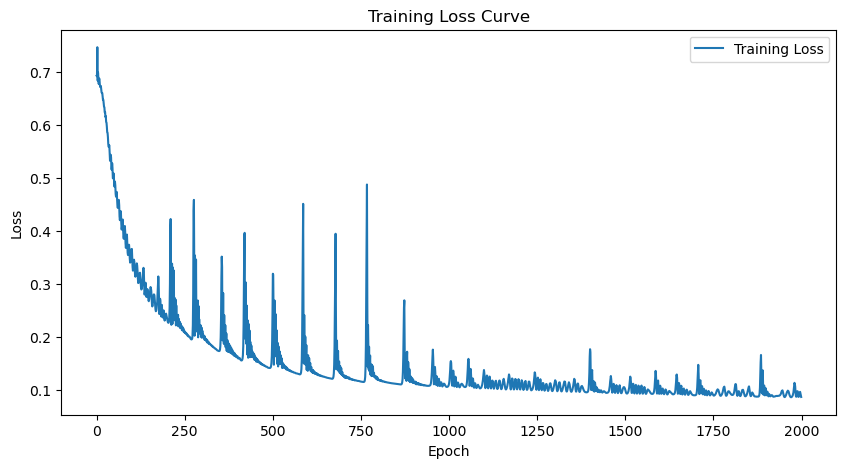

Final Model Accuracy: 84.47%
Final Model F1-score: 0.8543


In [20]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [21]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.92      0.76      0.83       194
non_infringement       0.79      0.93      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.85      0.84       380
    weighted avg       0.86      0.84      0.84       380



/tmp/ipykernel_69084/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 